# Convolutional LSTM for action prediction

- keep track of best validation value + Save checkpoints with information (autosave)
- clean naming (of how models are saved, configs are saved, runs are called)
- confusion matrix of result
- wandb/ tensorboard integration (also for gradient information?)
- hydra integration for hyperparameters?

### Imports

In [14]:
import pickle
import hydra
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

### Load datasets

In [5]:
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

### Preprocess data

In [106]:
def sliding_windows(dataset, seq_length):    
    x_actions = []
    y_actions = []

    actions = dataset['actions']
    imgs = dataset['observations']
    
    # preprocess actions
    actions = [[i] for i in actions]
    
    # preprocess images
    x_imgs = []
    for img in imgs:
        img = torch.from_numpy(img).float()
        img = img.permute(2, 0, 1)
        x_imgs.append(img)
    x_imgs_processed = torch.stack(x_imgs)
    
    # actual sliding window
    x_imgs = []
    for i in range(len(actions)-seq_length-1):
        _x_actions = actions[i:(i+seq_length)]
        _x_imgs = x_imgs_processed[i:(i+seq_length)]
        _y_actions = actions[i+1+seq_length] # _y = data[i+seq_length]
        
        x_actions.append(_x_actions)
        x_imgs.append(_x_imgs)
        y_actions.append(_y_actions)
        
    x_imgs = torch.stack(x_imgs)

    return np.array(x_actions), x_imgs, np.array(y_actions) # train, val. data

seq_length = 20
x_acts, x_imgs, y_acts = sliding_windows(oracle_data, seq_length)

# seq. length x 3 x 32 x 32

In [107]:
from torch.autograd import Variable

train_size = int(len(y_acts) * 0.67)
test_size = len(y_acts) - train_size

# full data set
dataX_acts = Variable(torch.Tensor(np.array(x_acts)))
dataX_imgs = Variable(torch.Tensor(x_imgs))
dataY_acts = Variable(torch.Tensor(np.array(y_acts)))

# training set and validation set split
trainX_acts = Variable(torch.Tensor(np.array(x_acts[0:train_size])))
trainX_imgs = Variable(torch.Tensor(np.array(x_imgs[0:train_size])))
trainY_acts = Variable(torch.Tensor(np.array(y_acts[0:train_size])))

testX_acts = Variable(torch.Tensor(np.array(x_acts[train_size:len(x_acts)])))
testX_imgs = Variable(torch.Tensor(np.array(x_imgs[train_size:len(x_imgs)])))
testY_acts = Variable(torch.Tensor(np.array(y_acts[train_size:len(y_acts)])))

In [108]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [109]:
print(len(trainX_acts[0][0]))

1


In [110]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 20
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss() # MSELoss - regression, CrossEntropyLoss for labels
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX_acts)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY_acts)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 200 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 4.08592
Epoch: 200, loss: 0.14944
Epoch: 400, loss: 0.15153
Epoch: 600, loss: 0.12619
Epoch: 800, loss: 0.10598
Epoch: 1000, loss: 0.10563
Epoch: 1200, loss: 0.10560
Epoch: 1400, loss: 0.10558
Epoch: 1600, loss: 0.10558
Epoch: 1800, loss: 0.10557


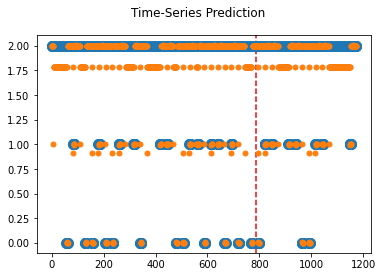

In [114]:
from matplotlib import pyplot as plt

lstm.eval()
train_predict = lstm(dataX_acts)

data_predict = train_predict.data.numpy()
dataY_plot = dataY_acts.data.numpy()

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, 'o', markersize=10)
plt.plot(data_predict, 'o', markersize=5)
plt.suptitle('Time-Series Prediction')
plt.show()

### Initialize models

In [4]:
# https://stackoverflow.com/questions/52138290/how-can-we-define-one-to-one-one-to-many-many-to-one-and-many-to-many-lstm-ne

# enable model to work with different sequence lengths
# wandb and tensorboard integration

# write model summary into runs folder

### Tensorboard integrations

In [5]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
# hydra integration for hyperparameters
import hydra
from omegaconf import OmegaConf
import datetime


hydra.core.global_hydra.GlobalHydra.instance().clear()

hydra.initialize(version_base=None, config_path='conf') # Assume the configuration file is in the current folder
cfg = hydra.compose(config_name='config')

print(cfg)
print(cfg.params.lr)

print(OmegaConf.to_yaml(cfg))

local_time = str(datetime.datetime.now().isoformat())
name = local_time + '_configs'
OmegaConf.save(cfg, "runs/"+name)

### Train model

In [6]:
# track best validation value
# save model during training

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in DualInput_model.state_dict():
    print(param_tensor, "\t", DualInput_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:


NameError: name 'DualInput_model' is not defined

### Plot loss and accuracy curves

In [ ]:
# look into confusion matrix